In [ ]:
import math
import matplotlib.pyplot as plt
import scipy
import cv2
import numpy as np
import glob
import os
import pandas as pd
import tensorflow as tf
import itertools
import random
from random import shuffle
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
train_dir=Path('training/training/')
test_dir=Path('validation/validation/')

In [ ]:
cols=['Label','Latin Name','Common Name','Train Images','Validation Images']
labels=pd.read_csv("monkey_labels.txt",names=cols,skiprows=1)
labels

In [ ]:
labels=labels['Common Name']
labels

In [ ]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir=Path('training/training/'+label)
        imgfile=random.choice(os.listdir(imgdir))
        img=cv2.imread('training/training/'+label+'/'+imgfile)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

In [ ]:
print(labels[4])
image_show(3,'n4')

In [ ]:
LR=1e-3
height=150
width=150
channels=3
seed=1337
batch_size=64
num_classes=10
epochs=200
data_augmentation=True
num_predictions=20
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator=train_datagen.flow_from_directory(train_dir,
target_size=(height,width),
batch_size=batch_size,
seed=seed,
shuffle=True,
class_mode='categorical',
)
test_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=test_datagen.flow_from_directory(test_dir,
target_size=(height,width),
batch_size=batch_size,
seed=seed,
shuffle=False,
class_mode='categorical')
train_num=train_generator.samples
validation_num=validation_generator.samples

In [ ]:
# model=Sequential()
# model.add(Conv2D(32,(3,3),input_shape=(150,150,3),strides=2))
# model.add(Activation('relu'))

# model.add(BatchNormalization())
# model.add(Conv2D(32,(3,3),strides=2))
# model.add(Activation('relu'))

# model.add(BatchNormalization())
# model.add(Conv2D(64,(3,3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64,(3,3),strides=2))
# model.add(Activation('relu'))

# model.add(Conv2D(512,(1,1),strides=2))
# model.add(Activation('relu'))
# model.add(Conv2D(num_classes,(1,1)))
# model.add(GlobalAvgPool2D())
# model.add(Activation('softmax'))


model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['acc'])
model.summary()

In [ ]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint=ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]

In [13]:
history=model.fit(train_generator,
                            steps_per_epoch=train_num//batch_size,
                            epochs=5,
                            validation_data=train_generator,
                            validation_steps=validation_num//batch_size,
                            callbacks=callbacks_list,
                            verbose=1
                            )

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.6017 - acc: 0.4265
Epoch 00001: val_acc improved from 0.39453 to 0.42578, saving model to c:\Users\acer\Documents\python\monkey_classifier\model.h5f
INFO:tensorflow:Assets written to: c:\Users\acer\Documents\python\monkey_classifier\model.h5f\assets
17/17 [==============================] - 40s 2s/step - loss: 1.6017 - acc: 0.4265 - val_loss: 1.4307 - val_acc: 0.4258
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.5404 - acc: 0.4362
Epoch 00002: val_acc improved from 0.42578 to 0.48828, saving model to c:\Users\acer\Documents\python\monkey_classifier\model.h5f
INFO:tensorflow:Assets written to: c:\Users\acer\Documents\python\monkey_classifier\model.h5f\assets
17/17 [==============================] - 68s 4s/step - loss: 1.5404 - acc: 0.4362 - val_loss: 1.4088 - val_acc: 0.4883
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1.5396 - acc: 0.4410
Epoch 00003: val_acc improved from 0

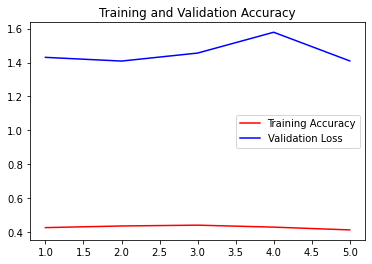

In [14]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.title('Training and Validation Accuracy')
plt.plot(epochs,acc,'red',label='Training Accuracy')
plt.plot(epochs,val_loss,'blue',label='Validation Loss')

plt.legend()

plt.show()

In [15]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

Instructions for updating:
Please use Model.predict, which supports generators.


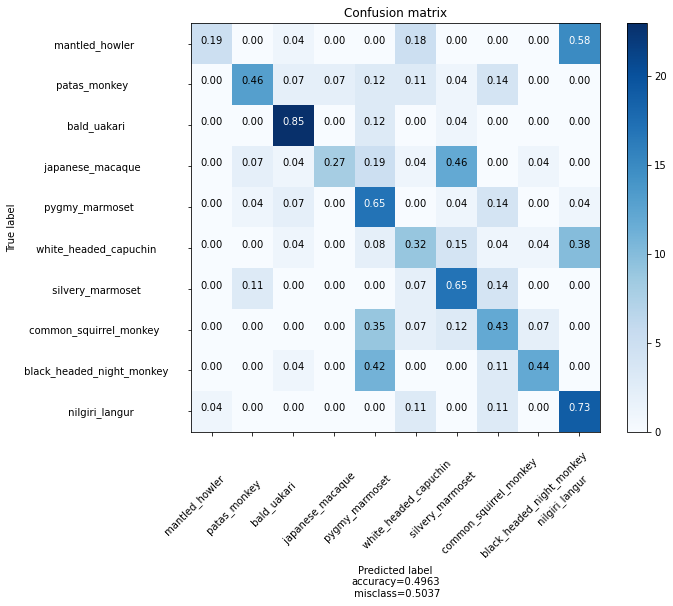

In [18]:
from tensorflow.keras.models import load_model
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [19]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.83      0.19      0.31        26
 patas_monkey                         0.68      0.46      0.55        28
 bald_uakari                          0.74      0.85      0.79        27
 japanese_macaque                     0.80      0.27      0.40        30
 pygmy_marmoset                       0.34      0.65      0.45        26
 white_headed_capuchin                0.36      0.32      0.34        28
 silvery_marmoset                     0.44      0.65      0.52        26
 common_squirrel_monkey               0.39      0.43      0.41        28
 black_headed_night_monkey            0.75      0.44      0.56        27
 nilgiri_langur                       0.42      0.73      0.54        26

                       accuracy                           0.50       272
                      macro avg       0.58      0.50      0.49       272
                   weighted avg       0.58      0

In [25]:
test_list = os.listdir("C:/Users/acer/Documents/python/monkey_classifier")
test_list.sort()
print(test_list)
model_test = load_model(filepath)

['.git', '.ipynb_checkpoints', 'download.jpg', 'main.ipynb', 'model.h5f', 'monkey_labels.txt', 'test.ipynb', 'training', 'validation']
